In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [3]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [5]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


fashion_mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = FashionMNIST(dataset_path, transform=fashion_mnist_transform, train=True, download=True)
test_dataset  = FashionMNIST(dataset_path, transform=fashion_mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 26421880/26421880 [00:03<00:00, 8610550.83it/s] 


Extracting /home/nashir/datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/nashir/datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 249364.74it/s]


Extracting /home/nashir/datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/nashir/datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3602806.41it/s]


Extracting /home/nashir/datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/nashir/datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8612794.97it/s]

Extracting /home/nashir/datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/nashir/datasets/FashionMNIST/raw



In [6]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [13]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [14]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

In [15]:
losses = []

In [16]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        losses.append(loss.item())
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  291.2446929778798
	Epoch 2 complete! 	Average Loss:  256.30705296588064
	Epoch 3 complete! 	Average Loss:  250.6274953372809
	Epoch 4 complete! 	Average Loss:  247.86710979888355
	Epoch 5 complete! 	Average Loss:  246.28045968541318
	Epoch 6 complete! 	Average Loss:  245.14492040771077
	Epoch 7 complete! 	Average Loss:  244.37963467758766
	Epoch 8 complete! 	Average Loss:  243.7725959607158
	Epoch 9 complete! 	Average Loss:  243.29680470054257
	Epoch 10 complete! 	Average Loss:  242.89662686508765
	Epoch 11 complete! 	Average Loss:  242.45038025615608
	Epoch 12 complete! 	Average Loss:  242.06729529684893
	Epoch 13 complete! 	Average Loss:  241.70417714419867
	Epoch 14 complete! 	Average Loss:  241.40011911127922
	Epoch 15 complete! 	Average Loss:  241.09720139033806
	Epoch 16 complete! 	Average Loss:  240.81773727697203
	Epoch 17 complete! 	Average Loss:  240.56719998826168
	Epoch 18 complete! 	Average Loss:  240.4314363783389
	

In [17]:
import matplotlib.pyplot as plt

In [20]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [25]:
def show_image(x, idx, ax):
    x = x.view(batch_size, 28, 28)
    ax.imshow(x[idx].cpu().numpy())

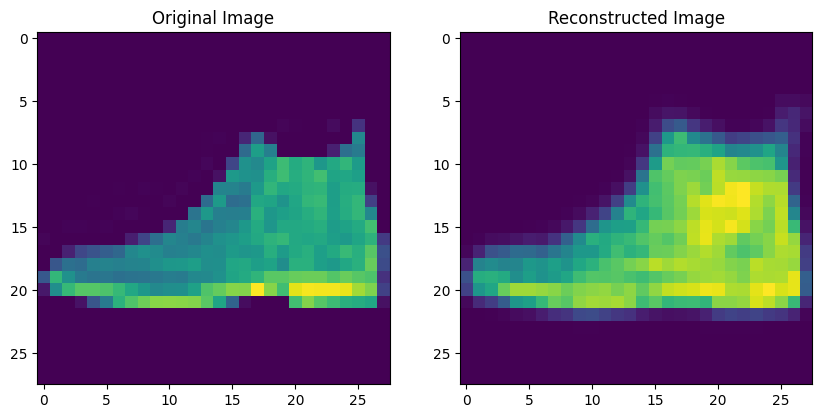

In [29]:
# Create 2x1 subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
show_image(x, idx=0, ax=ax[0])
ax[0].set_title("Original Image")
show_image(x_hat, idx=0, ax=ax[1])
ax[1].set_title("Reconstructed Image")
plt.show()